In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import glob
import sys
from astroquery.jplhorizons import Horizons

In [4]:
### Change as required
main_dir = '/Users/s1523386/Documents/year1/shape_modelling/162p/'
lc_dir = main_dir+'LC_prep/raw_combined/'
target = '162p'
date = '20210602'
lam = '200'
beta = '-80'
best_shifts = main_dir+'best_scaling_'+date+'_rel_combined.txt'


In [5]:
files = sorted(glob.glob(lc_dir+target+'*R.txt'))
# Check this read correctly
if len(files)==0:
    print('Problem loading LC files, check path.')
    sys.exit()
else:
    print('%i LC files found for %s.'%(len(files), target))
    print('First file in list = ', files[0])

12 LC files found for 162p.
First file in list =  /Users/s1523386/Documents/year1/shape_modelling/162p/LC_prep/raw_combined/162p_20070517_950_R.txt


In [6]:
# read in best shifts as output from matlab script
shifts = []
f = open(best_shifts, 'r')
lines = f.readlines()
for line in lines:
    data=line.split()
    shifts.append(float(data[0]))
shifts

[-0.121,
 -0.153,
 -0.091,
 0.236,
 -0.228,
 -0.232,
 -0.055,
 0.155,
 -0.075,
 -0.101,
 0.006,
 -0.057]

In [5]:
"""# Function to convert intensities back to magnitudes

def int2mag(i,m0):
    m = m0-2.5*np.log10(i)
    return m

# Testing whether the order of subtracting the shift from the intensity before converting back to magnitude matters

ints1=[0.67670596,0.67421747,0.68738492,0.68108294,0.68548823,0.69246846,0.66435468,0.69374521,0.65584317,0.67795364,0.67173813,0.66742120 ,0.66680677]
print(ints1)
shifted_ints1=np.array(ints1)-shifts[0]

shifted_mags_test=np.zeros_like(shifted_ints1)

for i,intensity in enumerate(shifted_ints1):
    shifted_mags_test[i]=int2mag(intensity, 20)
shifted_mags_test
print(np.mean(shifted_mags_test))""";

In [7]:
# Magnitudes found in the second column of each LC file, JD in first
# Calculate mean magnitude from each LC as it's read in
mjd_start = []
mjd_all=[]
mag = []
mean_mag = []
mag_all = []
mag_unc=[]
mjd = []
npoints=np.zeros(len(files))

for i,file in enumerate(files):
    
    count = 0
    f = open(file, 'r')
    lines = f.readlines()
    for line in lines:
        data = line.split()
        mjd_all.append(float(data[0]))
        mjd.append(float(data[0]))
        mag.append(float(data[1]))
        mag_all.append(float(data[1]))
        mag_unc.append(float(data[2]))
        count = count+1
    npoints[i] = int(count)
    mjd_start.append(mjd[0])    # MJDs at start of observing run (mid-exposure)
    print('No. mags to take mean of =', len(mag))
    mean_mag.append(np.mean(mag))
    mjd = []
    mag = []
    
f.close()
mean_mag

No. mags to take mean of = 37
No. mags to take mean of = 30
No. mags to take mean of = 5
No. mags to take mean of = 17
No. mags to take mean of = 13
No. mags to take mean of = 29
No. mags to take mean of = 145
No. mags to take mean of = 79
No. mags to take mean of = 21
No. mags to take mean of = 151
No. mags to take mean of = 51
No. mags to take mean of = 40


[20.551199999999998,
 20.190483333333336,
 20.6787,
 21.30923529411765,
 20.867446153846153,
 20.828841379310344,
 20.242470344827584,
 20.429920253164553,
 20.1152,
 20.301982781456953,
 20.34077450980392,
 21.1971525]

In [8]:
# Shift the magnitudes by values in best_shifts
mags_shifted = np.array(mean_mag)-np.array(shifts)
for mag in mags_shifted:
    print(mag)

20.672199999999997
20.343483333333335
20.7697
21.073235294117648
21.095446153846154
21.060841379310343
20.297470344827584
20.274920253164552
20.1902
20.402982781456952
20.33477450980392
21.2541525


In [9]:
mjd_start

[2454238.473696,
 2456040.641995,
 2456071.546767,
 2456093.565922,
 2456096.568522,
 2456101.514543,
 2457802.571019,
 2457806.562837,
 2457811.582037,
 2458219.478059,
 2458227.457955,
 2458309.454704]

In [18]:
# Obtain telescope codes from files filenames to parse Horizons database
siteid = []
for file in files:
    siteid.append(file[88:91])
print(siteid)

['950', '309', '309', '809', '809', '309', '950', '950', '071', '950', '950', '809']


In [19]:
# Correct mid-exposure MJDs for light travel time before we obtain alphas, deltas and r_hs
# MJD_use = MJD_start-(delta/c)
au=1.496e11   #m
d2s=86400
mjd_use = []

for i,day in enumerate(mjd_start):
    obj = Horizons(id='90001062',location = siteid[i], epochs=day)
    eph = obj.ephemerides(quantities='20')
    deltcomet = float(eph['delta'])
    mjd_use.append(((mjd_start[i]*d2s)-((deltcomet*au)/3.e8))/d2s)

In [20]:
# Check these look resonable:
mjd_use

[2454238.4504419076,
 2456040.571266327,
 2456071.4737502034,
 2456093.490967207,
 2456096.4932989585,
 2456101.438880528,
 2457802.5503569725,
 2457806.5423623323,
 2457811.504141046,
 2458219.455531825,
 2458227.435531547,
 2458309.3739130935]

In [21]:
# Use light-time corrected MJDs to parse Horizons for delta, alpha, r_h
r_au = []
delta_au = []
alpha = []

for i in range(len(siteid)):
    obj = Horizons(id='90001063',location = siteid[i], epochs=mjd_use[i])
    eph = obj.ephemerides(quantities='1,19,20,24')
    
    r = float(eph['r'])
    r_au.append(r)
    
    delta = float(eph['delta'])
    delta_au.append(delta)
    
    alph = float(eph['alpha'])
    alpha.append(alph)

In [22]:
alpha

[7.5057,
 4.4883,
 9.892,
 11.8385,
 11.97,
 12.1195,
 9.8697,
 9.1704,
 8.2387,
 2.2635,
 0.3947,
 12.0582]

In [23]:
delta_au

[4.02881217842786,
 3.77885960724139,
 4.10533811709723,
 4.4432554656851,
 4.49279873836548,
 4.57531187787287,
 3.58012510885411,
 3.5476438468523,
 3.51221721097544,
 3.90318715732432,
 3.88515794404615,
 4.65580545832238]

In [24]:
r_au

[4.85769698213,
 4.728205159503,
 4.770694472818,
 4.79651977579,
 4.799756506763,
 4.804939593401,
 4.302234515353,
 4.314341046276,
 4.329198710774,
 4.890342120172,
 4.88900488379,
 4.8485101495]

In [25]:
# Defining funciton to calculate reduced magnitude H(1,1,alpha)
# Inputs:
#    m: magnitude
#    r: heliocentric distance (AU)
#    delta: geocentric distance (AU)

# Outputs:
#    h: H(1,1,0)
def mag_reduce(m, r, delta):
    h = m-(5*np.log10(r*delta))
    return h

In [26]:
# Generate reduced magnitudes
hmags = []
for i in range(len(mags_shifted)):
    hmags.append(mag_reduce(mags_shifted[i], r_au[i], delta_au[i]))
#hmags=mags_shifted

In [27]:
# Use alpha, reduced mags H(1,1,alpha) to calc least squares fit => phase slope
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(alpha,hmags)
print(slope, intercept, std_err, r_value)

0.04309203008239706 13.910912984769887 0.00289592532759648 0.9781557882858476


In [28]:
# Generate data to plot straight line
x = np.arange(0,max(alpha)+1,max(alpha)/100)
y = (slope*x)+intercept

In [29]:
# Reading in Rosita's errorbars

magunc=[]
magunc_use=[]

filename=main_dir+'TABLE_m_vs_alpha_RK.txt'

f=open(filename,'r')
lines=f.readlines()
for line in lines:
    data=line.split()
    magunc.append(float(data[4]))
print(len(magunc))
magunc_use.append(magunc[0])
for i in range(1,len(magunc)):
    if magunc[i]!=magunc[i-1]:
        magunc_use.append(magunc[i])
magunc_use.insert(9,0.0140)
print(magunc_use)
print(len(magunc_use))

647
[0.0476, 0.0378, 0.0289, 0.0209, 0.0394, 0.0208, 0.0356, 0.042, 0.014, 0.014, 0.0136, 0.0172, 0.0181, 0.0107, 0.0128, 0.0192, 0.0155, 0.02]
18


In [30]:
labels=['2007-05', '2012-04', '2012-05', '2012-06', '2017-02', '2018-04', '2018-07']

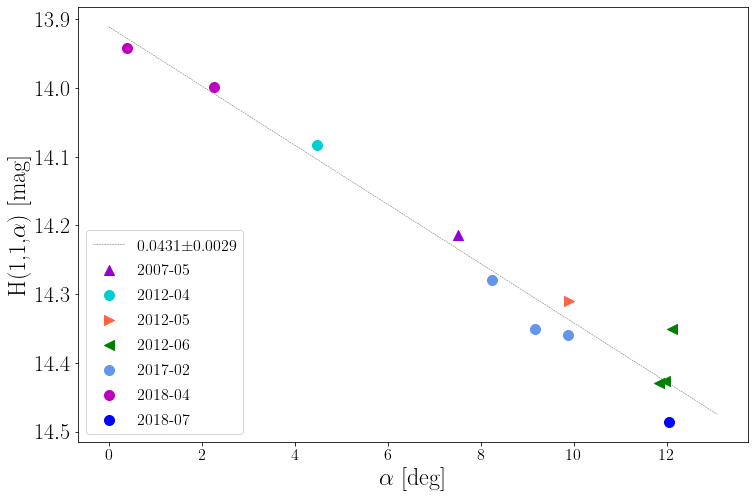

In [43]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

size = 100
lab = 24
leg = 16

plt.figure(figsize=(12,8))
#plt.scatter(alpha[0:3], hmags[0:3], label=labels[0],marker='^',s=size,color='darkviolet')
#plt.scatter(alpha[3:4], hmags[3:4], label=labels[1],marker='o',s=size,color='darkturquoise')
#plt.scatter(alpha[4:5], hmags[4:5], label=labels[2],marker='>',s=size, color='tomato')
#plt.scatter(alpha[5:8], hmags[5:8], label=labels[3],marker='<',s=size, color='green')
#plt.scatter(alpha[8:12], hmags[8:12], label=labels[4],marker='o',s=size,color='cornflowerblue')
#plt.scatter(alpha[12:15], hmags[12:15],label=labels[5],marker='o',s=size,color='m')
#plt.scatter(alpha[15:], hmags[15:],label=labels[6],marker='o',s=size,color='blue')

plt.scatter(alpha[:1], hmags[:1], label=labels[0],marker='^',s=size,color='darkviolet')
plt.scatter(alpha[1:2], hmags[1:2], label=labels[1],marker='o',s=size,color='darkturquoise')
plt.scatter(alpha[2:3], hmags[2:3], label=labels[2],marker='>',s=size, color='tomato')
plt.scatter(alpha[3:6], hmags[3:6], label=labels[3],marker='<',s=size, color='green')
plt.scatter(alpha[6:9], hmags[6:9], label=labels[4],marker='o',s=size,color='cornflowerblue')
plt.scatter(alpha[9:11], hmags[9:11],label=labels[5],marker='o',s=size,color='m')
plt.scatter(alpha[11:], hmags[11:],label=labels[6],marker='o',s=size,color='blue')

#plt.errorbar(alpha,hmags,yerr=magunc_use,fmt='|',color='gray',capsize=4)

plt.plot(x,y, color='dimgray', linestyle='--', linewidth = 0.5, label='%.4f'% slope+ r'$\pm$''%.4f'% std_err)
plt.gca().invert_yaxis()
plt.xlabel(r'$\alpha$'' [deg]', fontsize=lab)
plt.ylabel(r'H(1,1,'r'$\alpha$) [mag]', fontsize = lab)
#plt.title(target+' H(1,1,'r'$\alpha$) vs $\alpha$ long:'+lam+' lat:'+beta, fontsize = 16)
plt.xticks(fontsize=16); plt.yticks(fontsize=22)
plt.legend(loc=3,fontsize=leg)
plt.savefig(main_dir+'pictures/'+target+'_'+lam+'_'+beta+'_shifts_dist_cal.pdf', format='pdf')
#plt.show()

In [31]:
y_exp

array([14.12549517, 14.12549532, 14.12549547, 14.12549562, 14.12549577,
       14.12549592, 14.12549607, 14.12549622, 14.12549637, 14.12549652,
       14.12549667, 14.12549682, 14.12549696, 14.12549711, 14.12549726,
       14.12549741, 14.12549756, 14.12549771, 14.12549786, 14.12549801,
       14.12549816, 14.12549831, 14.12549846, 14.12549861, 14.12549876,
       14.12549891, 14.12549906, 14.12549921, 14.12549936, 14.12549951,
       14.12549966, 14.12549981, 14.12549996, 14.12550011, 14.12550026,
       14.12550041, 14.12550056, 14.12550071, 14.12550085, 14.125501  ,
       14.12550115, 14.1255013 , 14.12550145, 14.1255016 , 14.12550175,
       14.1255019 , 14.12550205, 14.1255022 , 14.12550235, 14.1255025 ,
       14.12550265, 14.1255028 , 14.12550295, 14.1255031 , 14.12550325,
       14.1255034 , 14.12550355, 14.1255037 , 14.12550385, 14.125504  ,
       14.12550415, 14.1255043 , 14.12550445, 14.1255046 , 14.12550474,
       14.12550489, 14.12550504, 14.12550519, 14.12550534, 14.12